# Попробуем сделать классификатор для положительных и отрицательных отзывов

In [48]:
import pandas as pd

In [49]:
# загрузим распарсенные данные заранее(из раздела полезные и по веремени)
from os import walk

all_part_files = []
union_df = pd.DataFrame(columns=['text', 'name_user', 'date', 'rating'])

for (dirpath, dirnames, filenames) in walk('data_reviews_by_time/'):
    files = [l for l in filenames if not l.startswith('.')]
    files = ['data_reviews_by_time/'+ file for file in files]
    all_part_files.extend(files)    
    break

for (dirpath, dirnames, filenames) in walk('data_reviews_by_useful/'):
    files = [l for l in filenames if not l.startswith('.')]
    files = ['data_reviews_by_useful/'+ file for file in files]
    all_part_files.extend(files)    
    break

for file in all_part_files:
    df = pd.read_csv(file, delimiter='\t', header=None,
                     names = ['text', 'name_user', 'date', 'rating'])
    union_df = pd.concat([df, union_df], ignore_index=True)


In [50]:
# у кого оценка больше 3 будем считать положительными
union_df["review_positive"] = union_df.rating.apply(lambda x: 1 if x > 3 else 0)

In [51]:
# посомтрим, что у нас есть
union_df.shape

(5466, 5)

In [52]:
union_df.head()

,text,name_user,date,rating,review_positive
0,Приложение не обновляется и не скачивается за...,Sasha Pershina,9 июля 2017 г.,1.0,0
1,Хорошее приложение облегчает платежи,Oleg S,9 июля 2017 г.,5.0,1
2,Нет придела совершенству. Практичное приложен...,Евгения Ключникова,9 июля 2017 г.,4.0,1
3,Нормас работает,,9 июля 2017 г.,4.0,1
4,"Удобное приложение, основные функции отрабаты...",,9 июля 2017 г.,5.0,1


In [53]:
union_df.text = union_df.text.apply(lambda x: ' '.join([w if w.isalpha() 
                                                        else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

In [54]:
# векторизация
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, lowercase=True)

In [55]:
X = vectorizer.fit_transform(union_df.text).toarray()

In [56]:
y = union_df.review_positive

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [58]:
y_train.value_counts()

1    3147
0    1225
Name: review_positive, dtype: int64

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import metrics

In [60]:
depths = np.arange(2, 15, 2)
grid = {'max_depth': depths}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=10)

In [61]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [62]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)[:10]

/Users/rogotulka/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87649, std: 0.01623, params: {'max_depth': 14},
 mean: 0.86528, std: 0.01689, params: {'max_depth': 12},
 mean: 0.85704, std: 0.01880, params: {'max_depth': 10},
 mean: 0.84469, std: 0.02129, params: {'max_depth': 8},
 mean: 0.83303, std: 0.01882, params: {'max_depth': 6},
 mean: 0.82571, std: 0.01800, params: {'max_depth': 4},
 mean: 0.80947, std: 0.01612, params: {'max_depth': 2}]

In [63]:
clf = DecisionTreeClassifier(max_depth=14)

In [64]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [65]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [66]:
metrics.accuracy_score(y_test, y_pred)

0.87385740402193779

# Добавим к CountVectorizer stop words

In [67]:
# попробуем выкинуть stop слова
stop_words = None
with open('stop-words.txt', 'r') as file:
    stop_words = file.readlines()
stop_words = [word.replace('\n', '') for word in stop_words]

In [68]:
vectorizer = CountVectorizer(max_features=5000, lowercase=True, stop_words=stop_words)

In [69]:
X = vectorizer.fit_transform(union_df.text).toarray()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [71]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [72]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [73]:
metrics.accuracy_score(y_test, y_pred)

0.86380255941499084

# Добавим stemmer

In [74]:
from nltk.stem import SnowballStemmer
import re
stemmer = SnowballStemmer("russian")
stem = union_df.text.apply(lambda x: ' '.join([stemmer.stem(i) for i in re.split('[?., ]', x.strip())]))

In [75]:
vectorizer = CountVectorizer(max_features=5000, lowercase=True, stop_words=stop_words)

In [76]:
X = vectorizer.fit_transform(stem).toarray()

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [78]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [79]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Посмотрим на метрики

In [80]:
metrics.accuracy_score(y_test, y_pred)

0.86197440585009144

In [81]:
metrics.precision_score(y_test, y_pred)

0.87528344671201819

In [82]:
metrics.recall_score(y_test, y_pred)

0.94956949569495697

In [83]:
metrics.f1_score(y_test, y_pred)

0.91091445427728623

In [84]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.82336191689319027

# Визуализация дерева

In [85]:
from sklearn.externals.six import StringIO 
from sklearn import tree
import pydot 
import pydotplus
import pydot
dotfile = StringIO()
tree.export_graphviz(clf, out_file=dotfile, feature_names=vectorizer.get_feature_names(), class_names=['bad','good'])
pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png("dtree.png")

True

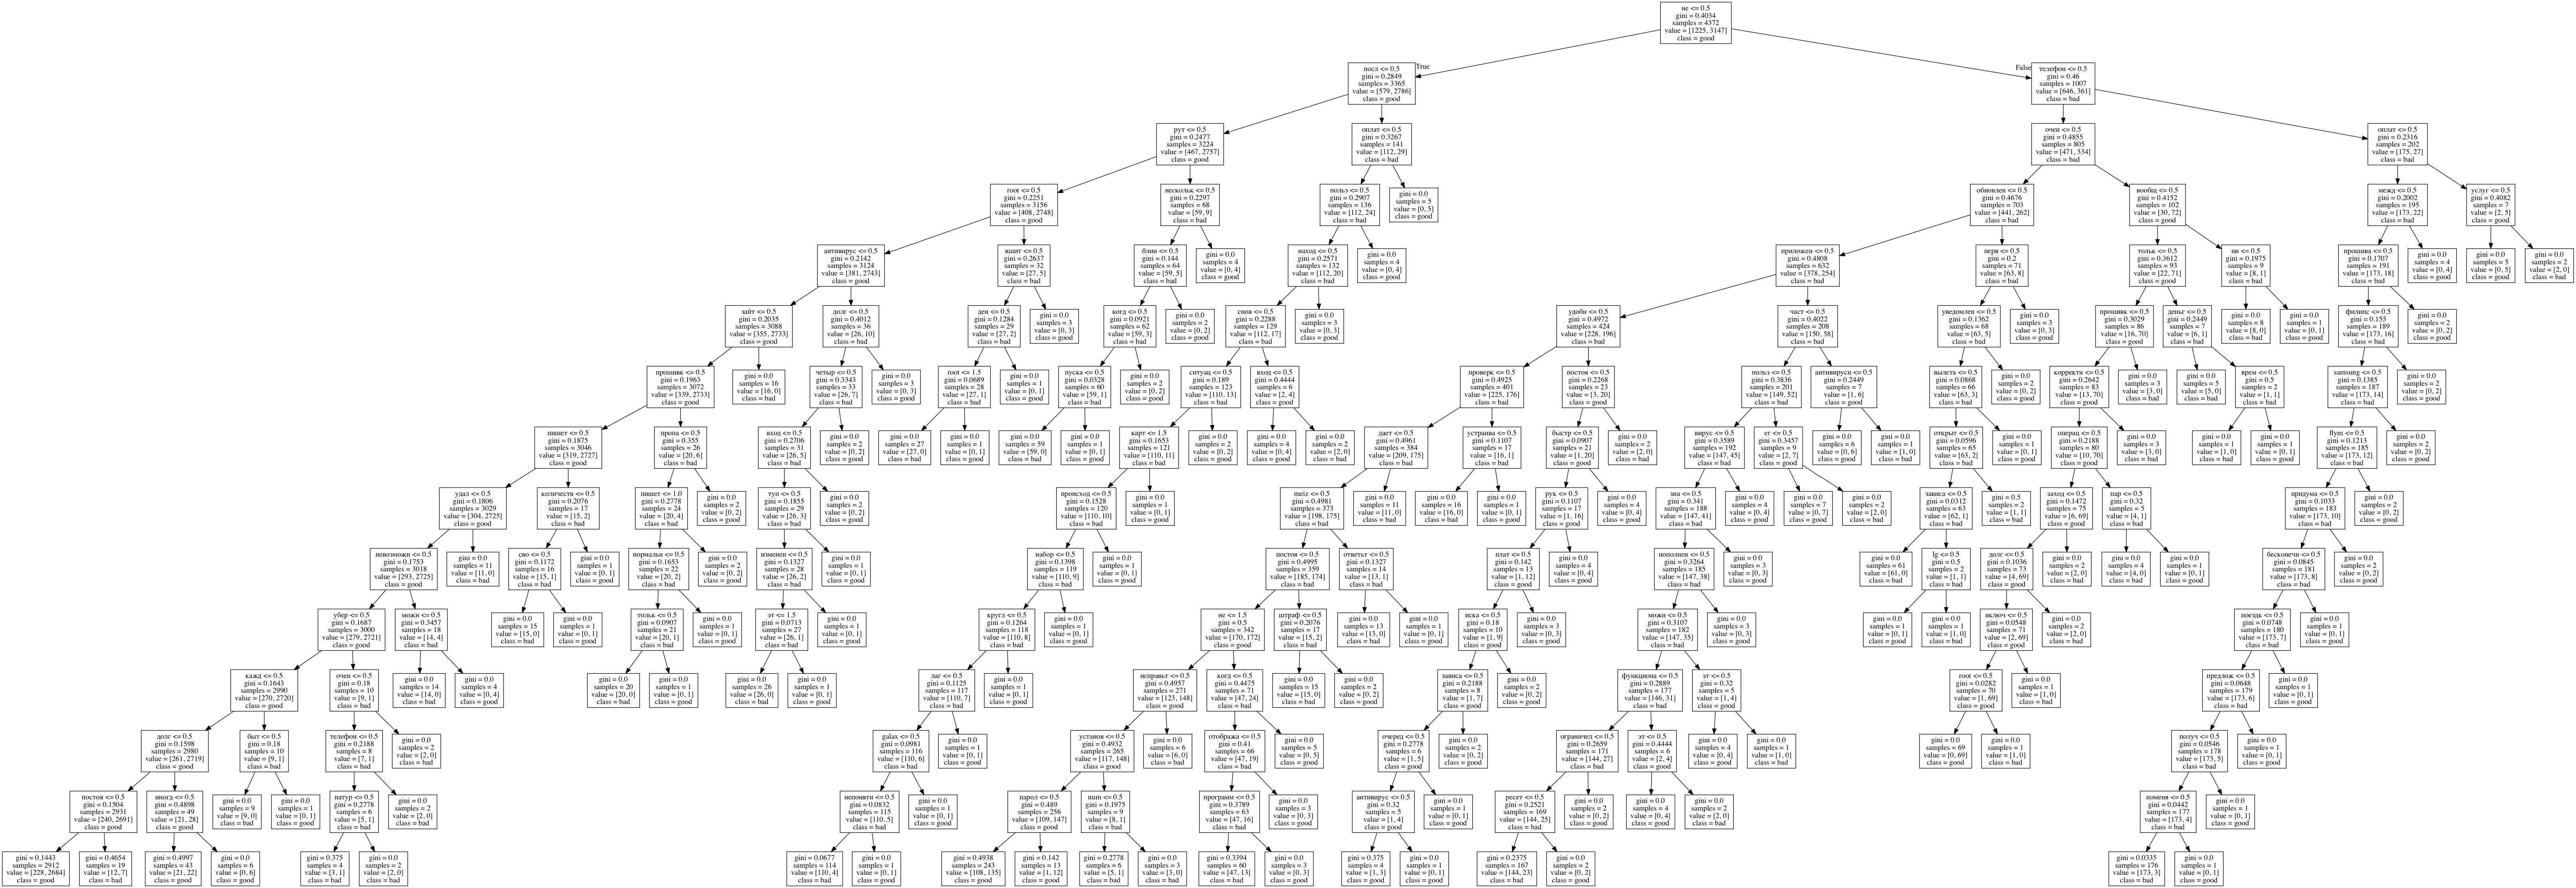

In [86]:
from IPython.display import Image
Image(filename='dtree.png')

# Посмотрим, где мы ошибаемся

In [87]:
y_pred = clf.predict(X)

In [88]:
# инетересно, на каких отзывах мы ошибаемся
[x for x in list(zip(union_df.text, y_pred, y)) if x[1] != x[2]]

[('Не могу Вылетает', 1, 0),
 ('Долго скачивается', 1, 0),
 ('Очень долго приходят смс', 1, 0),
 ('Не могу Вылетает', 1, 0),
 ('Долго скачивается', 1, 0),
 ('Очень долго приходят смс', 1, 0),
 ('Хорошее Приходится по num раза входить в тк выкидывает из Не показывает в истории поступления или если осуществляются не через а через',
  0,
  1),
 ('Все хорошо на день не загружается Инициализация антивируса и', 1, 0),
 ('Ошибка num немогу обновить', 1, 0),
 ('Дважды требует авторизацию отпечатком пальца', 1, 0),
 ('Ещё бы всякую хрень модно было бы отключать через приложение', 1, 0),
 ('Вылетает при попытке открыть список сохранённых Раньше такого не', 1, 0),
 ('Приложение перестало Ошибка num', 1, 0),
 ('Меня не устраивает что при пользовании услуга мобильный Из крайности в все либо',
  1,
  0),
 ('Медленно и долго загружается', 1, 0),
 ('Приложение удобное Оплачивать счета производить денежные переводы в любом месте где есть инет или Единственное что замедляет работу это антивирус не Проду